In [1]:
library(ggplot2)
library(patchwork)
library(ggthemes)

In [2]:
samples <- c('KI_1_1',
             'KI_1_2',
             'KI_1_3',
             'KI_1_4',
             'KI_1_5')

In [3]:
d.ls <- lapply(samples,function(x){
    d <- read.delim(file = paste0('/data/proj/GCB_MB/spatial_cut-tag/Yale_Apr_2022_nano_Tn5/results2/',x,'/adaptors_stats.txt'),header = 0)
    return(d)
})
    


In [4]:
head(d.ls[[1]])


,V1,V2,V3,V4,V5,V6,V7,V8
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,read_1,8,None,None,32,NACGTGAT,CTCATACA,None
2,read_2,8,None,None,40,NACGTGAT,AACTGTCT,None
3,read_3,8,None,None,None,NACGTGAT,AACGTGAT,None
4,read_4,None,None,None,23,None,None,None
5,read_5,None,None,None,33,None,None,None
6,read_6,None,None,None,5,None,None,None


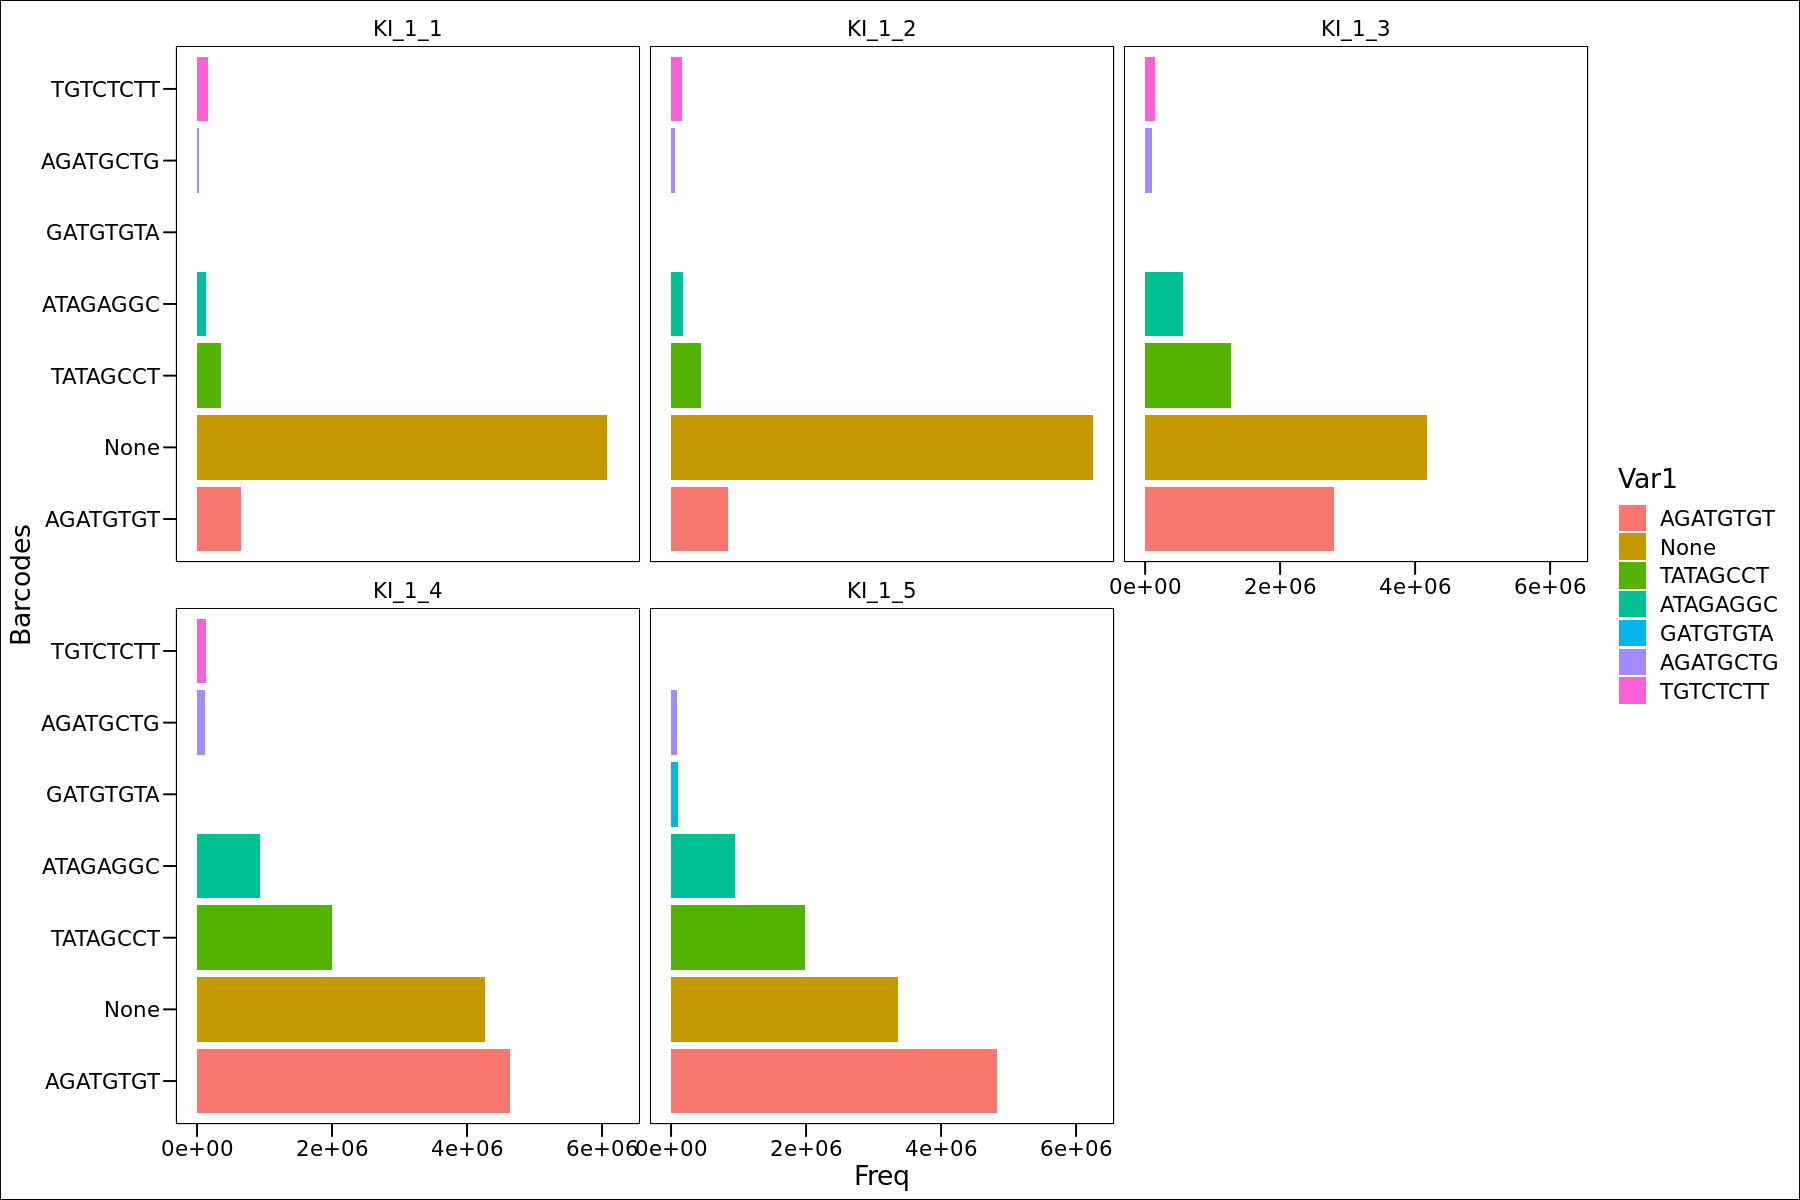

In [5]:
options(repr.plot.width=15, repr.plot.height=10)

df.gg.ls <- lapply(1:length(d.ls), function(x){
    bcd.summary               <- sort(table(d.ls[[x]]$V8), decreasing= TRUE)
    bcd.summary.ggplot        <- data.frame(head(bcd.summary,10))
    bcd.summary.ggplot$sample <- samples[x]
    head(bcd.summary.ggplot)
})

df.gg      <- do.call('rbind',df.gg.ls[length(df.gg.ls):1])
df.gg$Var1 <- as.factor(df.gg$Var1)

ggplot(data = df.gg) + 
      geom_bar(aes(y = Var1, x = Freq, fill = Var1),stat='identity') + 
      ylab("Barcodes") + theme_base() + facet_wrap(~sample)

In [6]:
d.filter.ls <- lapply(d.ls,function(x){
    all.bcd.obs.log <- x$V2 != "None" & x$V3 != "None" & x$V4 != "None"
    P7_found.log    <- x$V5 != "None"
    all.bcd.obs <- which(all.bcd.obs.log)
    P7_found    <- which(P7_found.log)

    x$status              <- 'barcode missing'
    x$status[P7_found]    <- 'barcode missing P7 found'
    x$status[all.bcd.obs] <- 'all barcodes found'
    x$P7_distance           <- 0
    x$P7_distance[P7_found]    <- x$V5[P7_found]
    x$P7_distance[all.bcd.obs] <- 140
    x
    })

In [7]:
barcode_found_table <- do.call('cbind',lapply(d.filter.ls,function(x){table(x$status)}))
colnames(barcode_found_table) <- samples
barcode_found_table

,KI_1_1,KI_1_2,KI_1_3,KI_1_4,KI_1_5
all barcodes found,1017690,1300173,4394348,7326675,7647358
barcode missing,258119,316512,652865,970999,963154
barcode missing P7 found,6285648,6484808,4362984,4300778,3183171


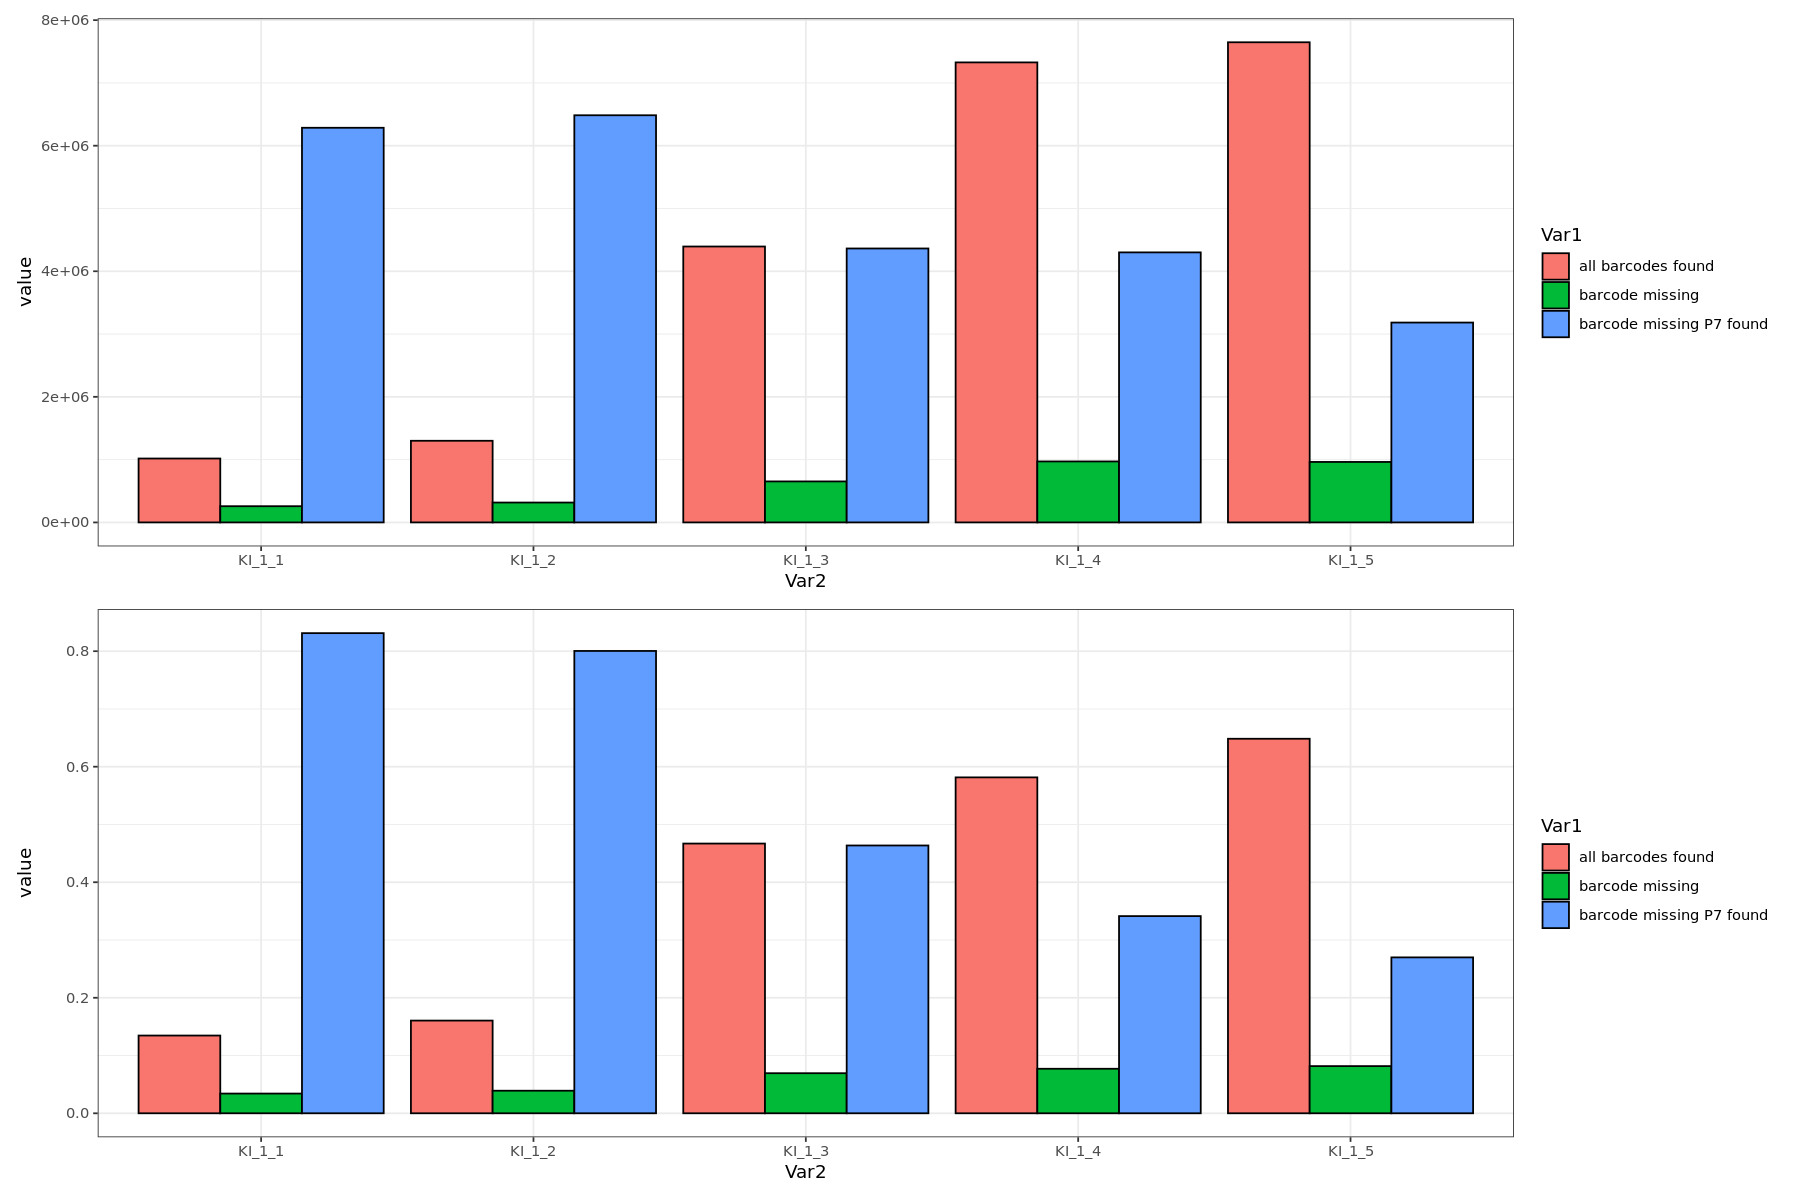

In [8]:
barcode_found_table_norm <- apply(barcode_found_table,2,function(x){x/sum(x)})
p1 <- ggplot(data = reshape2::melt(barcode_found_table)) + geom_bar(aes(fill = Var1, x = Var2, y = value),stat='identity',position=position_dodge(),col='black') + theme_bw()
p2 <- ggplot(data = reshape2::melt(barcode_found_table_norm)) + geom_bar(aes(fill = Var1, x = Var2, y = value),stat='identity',position=position_dodge(),col='black') + theme_bw()
p1/p2

In [9]:
head(d.filter.ls[[1]])

,V1,V2,V3,V4,V5,V6,V7,V8,status,P7_distance
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,read_1,8,None,None,32,NACGTGAT,CTCATACA,None,barcode missing P7 found,32
2,read_2,8,None,None,40,NACGTGAT,AACTGTCT,None,barcode missing P7 found,40
3,read_3,8,None,None,None,NACGTGAT,AACGTGAT,None,barcode missing,0
4,read_4,None,None,None,23,None,None,None,barcode missing P7 found,23
5,read_5,None,None,None,33,None,None,None,barcode missing P7 found,33
6,read_6,None,None,None,5,None,None,None,barcode missing P7 found,5


In [10]:
d.filter.ls <- lapply(d.filter.ls, function(x){x$P7_distance <- as.numeric(x$P7_distance);return(x) })


In [11]:
d.summary.ls     <- lapply(d.filter.ls,function(x){freq <- table(x$P7_distance); 
                                                   fraction <-freq/dim(x)[1]; 
                                                   df <- data.frame(cbind(freq,fraction)); 
                                                   df$l <- as.numeric(rownames(df)); return(df)
                                                  })

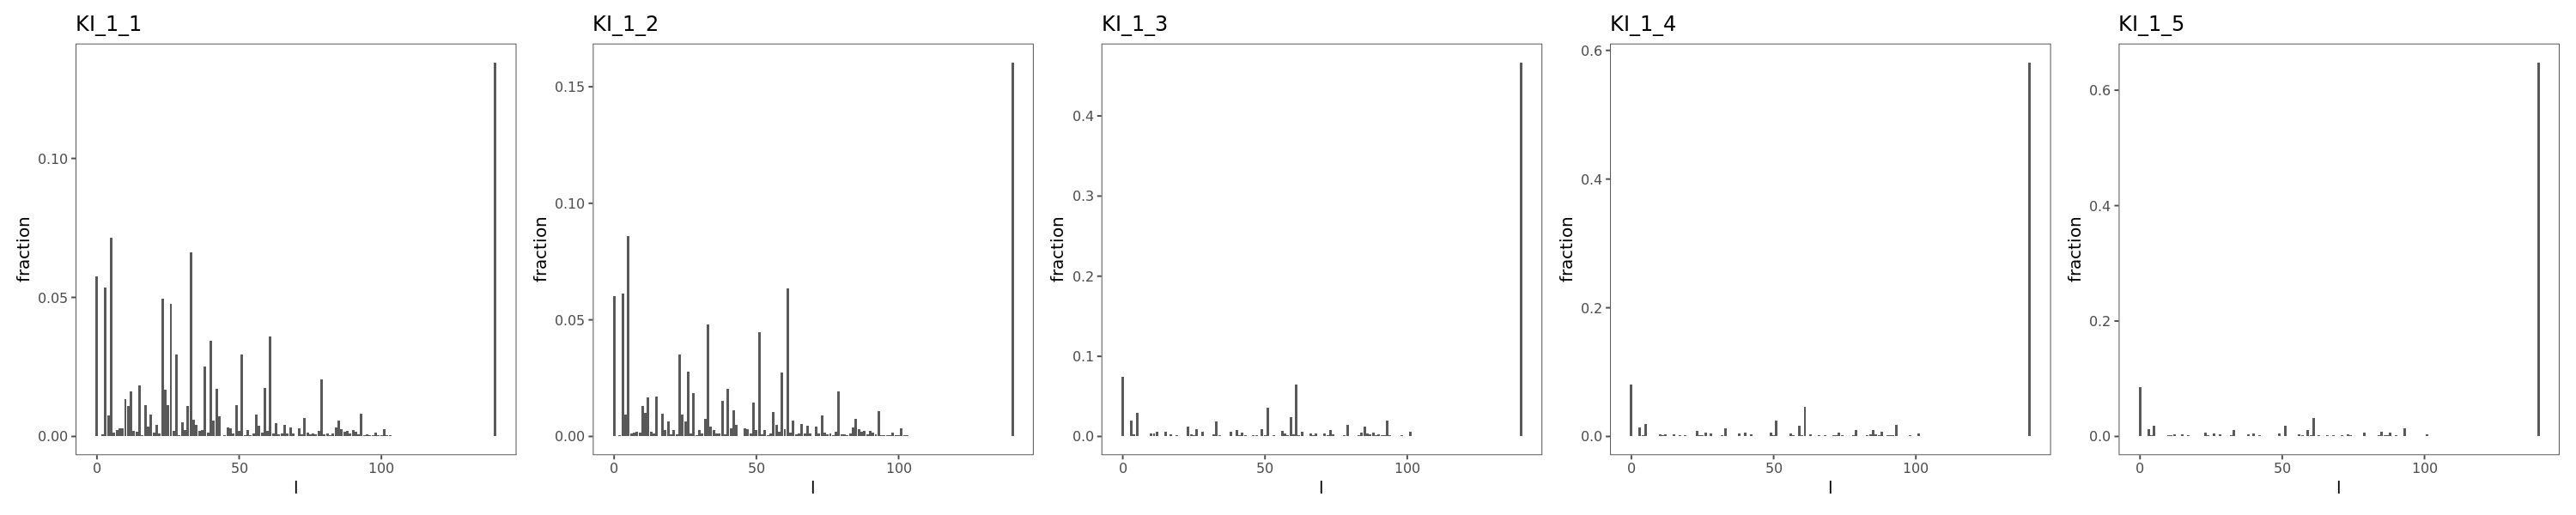

In [12]:
options(repr.plot.width=25, repr.plot.height=5)

wrap_plots(lapply(1:length(d.summary.ls),function(x){
    ggplot(data = d.summary.ls[[x]],aes(x = l,y = fraction)) + 
      geom_bar(stat='identity') + 
      theme(axis.text.x = element_text(angle=45)) +
      ggtitle(samples[x]) + theme_few() 
    }),nrow = 1)

In [13]:
lapply(d.summary.ls,tail,1)

,freq,fraction,l
,<dbl>,<dbl>,<dbl>
140,1017690,0.1345891,140
,freq,fraction,l
,<dbl>,<dbl>,<dbl>
140,1300173,0.1604856,140
,freq,fraction,l
,<dbl>,<dbl>,<dbl>
140,4394348,0.4669773,140
,freq,fraction,l
,<dbl>,<dbl>,<dbl>


In [14]:
library(rtracklayer)
library(GenomicRanges)
library(gridExtra)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


At

In [15]:
modalities <- c('ATAC','mod1','mod2')

In [16]:
m <- 'ATAC'

hist.ls <- lapply(samples,function(s){
    fragments.path  <- paste0('/data/proj/GCB_MB/spatial_cut-tag/Yale_Apr_2022_nano_Tn5/results2/',s,'/',m,'/bed/',s,'_fragments.bed')
    fragments.gr    <- rtracklayer::import(fragments.path)
    fragments.width <- width(fragments.gr)
    fragments.width <- data.frame(width=fragments.width[fragments.width < 1500])
    ggplot(data =fragments.width) + geom_histogram(aes(x = width),fill='white',col='black',binwidth=20) + theme_bw() + ggtitle(paste(s)) + coord_cartesian(xlim = c(0,1000))
    #hist(fragments.width,breaks=seq(0,2000,10))
})



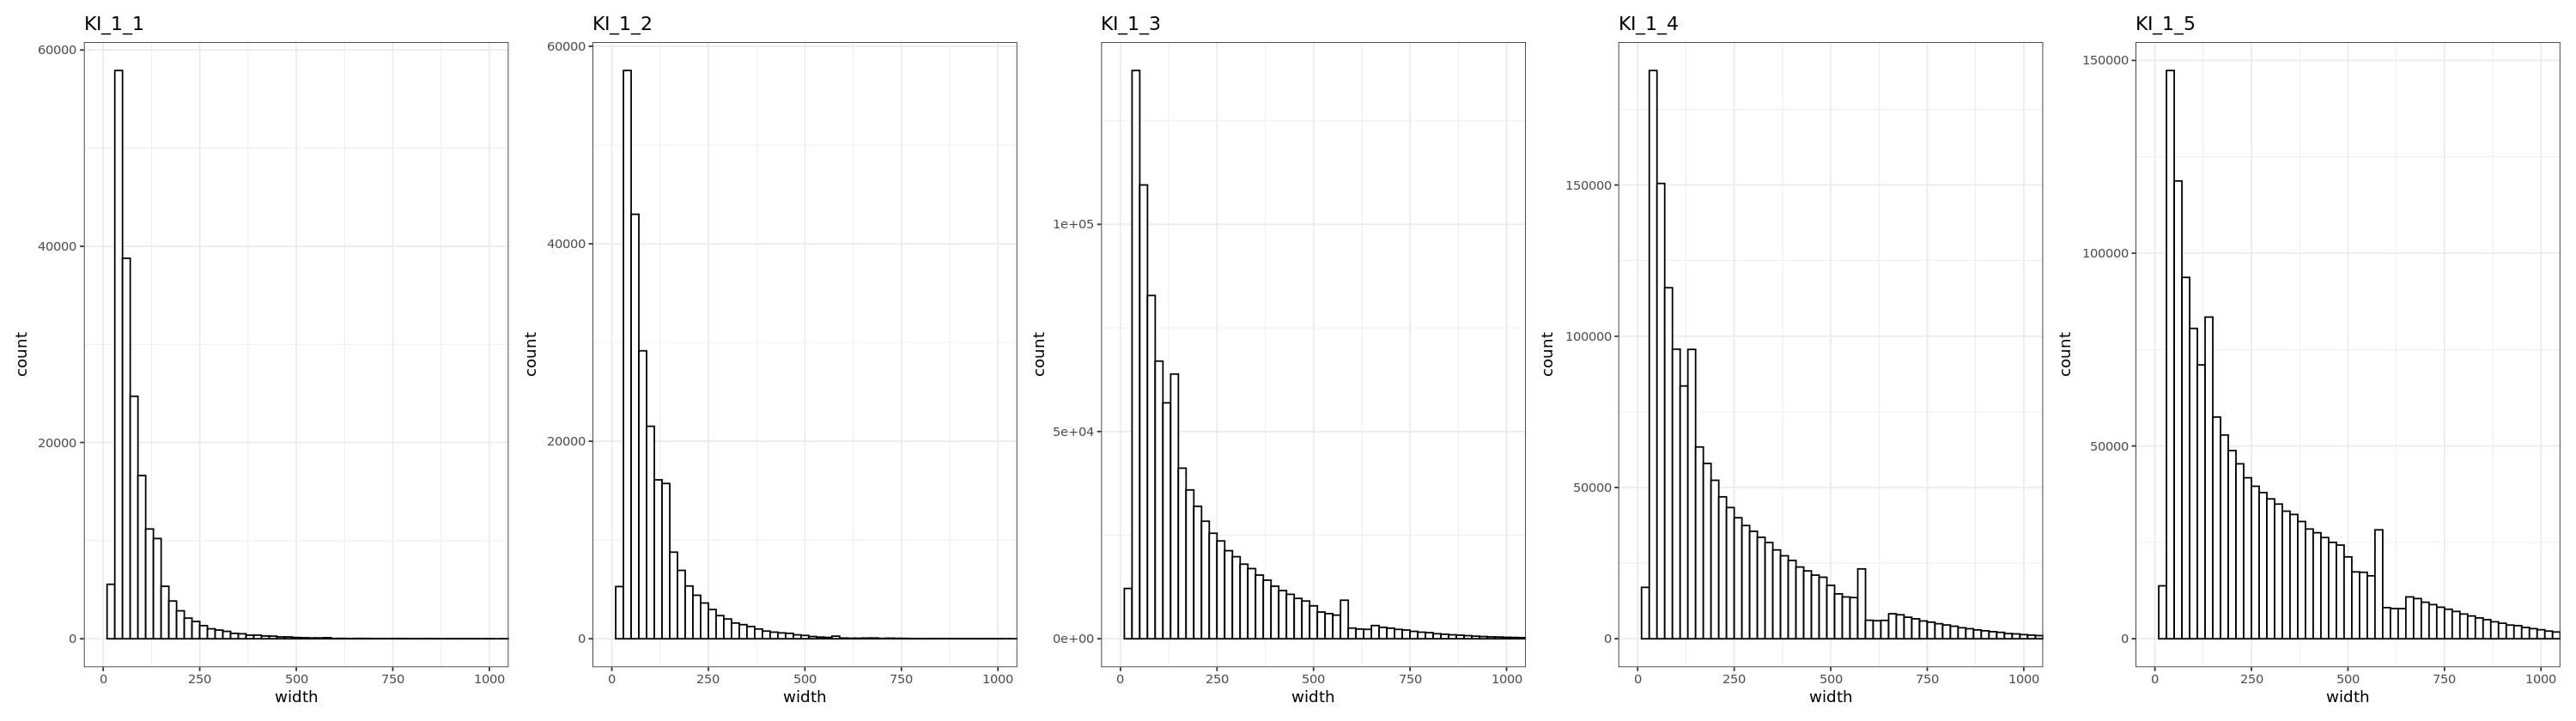

In [17]:
options(repr.plot.width=25, repr.plot.height=7)
wrap_plots(hist.ls,nrow=1)

In [18]:

hist.ls <- lapply(samples,function(s){
  lapply(list('ATAC'),function(m){
    fragments.path  <- paste0('/data/proj/GCB_MB/spatial_cut-tag/Yale_Apr_2022_nano_Tn5/results2/',s,'/',m,'/bed/',s,'_fragments.bed')
    fragments.gr    <- rtracklayer::import(fragments.path)
    fragments.width <- width(fragments.gr)
    fragments.width <- data.frame(width=fragments.width[fragments.width < 1500])
    ggplot(data =fragments.width) + geom_histogram(aes(x = width),fill='white',col='black') + theme_bw() + ggtitle(paste(s,m))
    #hist(fragments.width,breaks=seq(0,2000,10))
  })
})

options(repr.plot.width=15, repr.plot.height=5)

